In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
from tqdm import tqdm
from mdp_description import MDPDescription
from new_mdp_description import MDPDescription2, BoundType
from scipy.special import rel_entr
import pickle
from scipy.stats import bootstrap
from matplotlib.transforms import Affine2D
from riverswim import RiverSwim

np.random.seed(2)
colors = ['magenta','black', 'darkorange', 'blue', 'red']

def TV(p,q):
    return np.sum(np.abs(p-q)) * 0.5

def CE(x, c=1.96):
    return x.mean(0), c * x.std(0) / np.sqrt(x.shape[0])


import matplotlib as mpl
TITLE_SIZE = 24
LEGEND_SIZE = 15
TICK_SIZE = 15
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 18
FONT_SIZE = TITLE_SIZE-4


plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=AXIS_TITLE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXIS_LABEL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r'\usepackage{amsmath}',
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
        r'\usepackage{helvet}',    # set the normal font here
        r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
        r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
    ]
})

ns, na = 5,4
nk = 10

In [38]:

N_SIMS = 300
discount_factor = 0.99

values_U = np.zeros((N_SIMS))
values_U0 = np.zeros((N_SIMS, nk))
values_U1 = np.zeros((N_SIMS, nk))
values_minimax = np.zeros((N_SIMS))

values_polU_U0 = np.zeros((N_SIMS, nk))
values_polU_U1 = np.zeros((N_SIMS, nk))

policies_U = np.zeros((N_SIMS, ns, na))
policies_U0 = np.zeros((N_SIMS, nk, ns, na))
policies_U1 = np.zeros((N_SIMS, nk, ns, na))

TV_polU0_vs_polU = np.zeros((N_SIMS, nk))
TV_polU1_vs_polU = np.zeros((N_SIMS, nk))

gap_sq_min = np.zeros((N_SIMS))

for i in tqdm(range(N_SIMS)):
    P = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(ns, na)) #
    R = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(ns, na))

    mdp = MDPDescription(P, R, discount_factor)
    gap_sq_min[i] = mdp.delta_sq_min
    new_mdp = {}

    for k in range(1,nk+1):
        new_mdp[k] = MDPDescription2(P, R, discount_factor, moment_order_k=k)
        
    # Classical upper bound
    U_generative_policy, U_generative_value = mdp.compute_allocation()
    values_U[i] = U_generative_value
    policies_U[i] = U_generative_policy
    
    values_minimax[i] = ns*na / ((1-discount_factor)**3 * mdp.delta_sq_min)

    # U0
    val = list(map(lambda k: new_mdp[k].compute_allocation(type=BoundType.BOUND_1), range(1, nk+1)))
    new_b1_policies, new_b1_values = zip(*val)
    values_U0[i] = np.array(new_b1_values)
    policies_U0[i] = np.array(new_b1_policies)
    
    # U1
    val = list(map(lambda k: new_mdp[k].compute_allocation(type=BoundType.BOUND_2), range(1, nk+1)))
    new_b2_policies, new_b2_values = zip(*val)
    values_U1[i] = np.array(new_b2_values)
    policies_U1[i] = np.array(new_b2_policies)


    values_polU_U0[i] = np.array(list(map(lambda k: new_mdp[k].evaluate_allocation(U_generative_policy, type=BoundType.BOUND_1), range(1, nk+1))))
    values_polU_U1[i] = np.array(list(map(lambda k: new_mdp[k].evaluate_allocation(U_generative_policy, type=BoundType.BOUND_2), range(1, nk+1))))
    # U_b1_policies, U_b1_values = zip(*val)

    #>values_polU_U1[i] = np.array(list(map(lambda k: new_mdp[k].evaluate_allocation(U_generative_policy, type=BoundType.BOUND_2), range(1, nk+1))))
    # U_b2_policies, U_b1_values = zip(*val)

    # new_U_b1_values = np.array(list(map(lambda k: mdp.evaluate_allocation(new_b1_policies[k]), range(nk))))
    # new_U_b2_values = np.array(list(map(lambda k: mdp.evaluate_allocation(new_b2_policies[k]), range(nk))))
    
    TV_polU0_vs_polU[i] = list(map(lambda k: TV(new_b1_policies[k], U_generative_policy), range(nk)))
    TV_polU1_vs_polU[i] = list(map(lambda k: TV(new_b2_policies[k], U_generative_policy), range(nk)))
    
with open('./data/data_generative_randommdp.pkl', 'wb') as f:
    data = {
        'values_U': values_U,
        'values_U0': values_U0,
        'values_U1': values_U1,
        'values_polU_U0': values_polU_U0,
        'values_polU_U1': values_polU_U1,
        'policies_U': policies_U,
        'policies_U0': policies_U0,
        'policies_U1': policies_U1,
        'TV_polU0_vs_polU': TV_polU0_vs_polU,
        'TV_polU1_vs_polU': TV_polU1_vs_polU,
        'gap_sq_min': gap_sq_min,
        'values_minimax': values_minimax
    }
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 300/300 [26:56<00:00,  5.39s/it]


In [2]:
discount_factor = 0.99

values_U = 0
values_U0 = np.zeros(nk)
values_U1 = np.zeros(nk)
values_minimax = 0

values_polU_U0 = np.zeros(( nk))
values_polU_U1 = np.zeros((nk))

policies_U = 0
policies_U0 = np.zeros(nk)
policies_U1 = np.zeros(nk)

TV_polU0_vs_polU = np.zeros(nk)
TV_polU1_vs_polU = np.zeros(nk)

gap_sq_min = 0

from riverswim import RiverSwim


env = RiverSwim(num_states=20)

mdp = MDPDescription(env.transitions, env.rewards, discount_factor)
gap_sq_min = mdp.delta_sq_min
new_mdp = {}

for k in range(1,nk+1):
    new_mdp[k] = MDPDescription2(env.transitions, env.rewards, discount_factor, moment_order_k=k)
    
# Classical upper bound
U_generative_policy, U_generative_value = mdp.compute_allocation()
values_U = U_generative_value
policies_U = U_generative_policy

values_minimax = env.ns*env.na / ((1-discount_factor)**3 * mdp.delta_sq_min)

# U0
val = list(map(lambda k: new_mdp[k].compute_allocation(type=BoundType.BOUND_1), range(1, nk+1)))
new_b1_policies, new_b1_values = zip(*val)
values_U0 = np.array(new_b1_values)
policies_U0 = np.array(new_b1_policies)

val = list(map(lambda k: new_mdp[k].compute_allocation(type=BoundType.BOUND_2), range(1, nk+1)))
new_b2_policies, new_b2_values = zip(*val)
values_U1 = np.array(new_b2_values)
policies_U1 = np.array(new_b2_policies)

values_polU_U0 = np.array(list(map(lambda k: new_mdp[k].evaluate_allocation(U_generative_policy, type=BoundType.BOUND_1), range(1, nk+1))))
TV_polU0_vs_polU = list(map(lambda k: TV(new_b1_policies[k], U_generative_policy), range(nk)))

values_polU_U1 = np.array(list(map(lambda k: new_mdp[k].evaluate_allocation(U_generative_policy, type=BoundType.BOUND_2), range(1, nk+1))))
TV_polU1_vs_polU = list(map(lambda k: TV(new_b2_policies[k], U_generative_policy), range(nk)))
    
with open('./data/data_generative_riverswim.pkl', 'wb') as f:
    data = {
        'values_U': values_U,
        'values_U0': values_U0,
        'values_U1': values_U1,
        'values_polU_U0': values_polU_U0,
        'values_polU_U1': values_polU_U1,
        'policies_U': policies_U,
        'policies_U0': policies_U0,
        'policies_U1': policies_U1,
        'TV_polU0_vs_polU': TV_polU0_vs_polU,
        'TV_polU1_vs_polU': TV_polU1_vs_polU,
        'gap_sq_min': gap_sq_min,
        'values_minimax': values_minimax
    }
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
print('Random MDP')
P = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(ns, na)) #
R = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(ns, na))

mdp = MDPDescription(P, R, discount_factor)
MD = mdp.span_V_greedy ** 4/3
Var = mdp.var_V_greedy

print(mdp.var_V_greedy)
print('RiverSwim')
env = RiverSwim(num_states=20)
mdp = MDPDescription(env.transitions, env.rewards, discount_factor)

MD = mdp.span_V_greedy ** 4/3
Var = mdp.var_V_greedy
print(Var)


Random MDP
[[0.00174535 0.00142965 0.00088846 0.00066721]
 [0.00150148 0.00072674 0.00055637 0.00045893]
 [0.00070907 0.00166644 0.00183881 0.00049753]
 [0.00096444 0.0005236  0.00029482 0.00086685]
 [0.00066166 0.00057778 0.00057711 0.00048637]]
RiverSwim
[[0.         0.12483586]
 [0.         0.21116342]
 [0.         0.20696126]
 [0.         0.20284274]
 [0.         0.19880617]
 [0.         0.19484992]
 [0.         0.19097241]
 [0.         0.18717206]
 [0.         0.18344733]
 [0.         0.17979673]
 [0.         0.17621878]
 [0.         0.17271202]
 [0.         0.16927505]
 [0.         0.16590648]
 [0.         0.16260494]
 [0.         0.1593691 ]
 [0.         0.15619766]
 [0.         0.15308932]
 [0.         0.07226489]
 [0.         0.05402892]]


In [3]:
with open('./data/data_generative_randommdp.pkl', 'rb') as f:
    data = pickle.load(f)
    
with open('./data/data_generative_riverswim.pkl', 'rb') as f:
    data_riverswim = pickle.load(f)
    
random_values_U = data['values_U']
random_values_U0 = data['values_U0']
random_values_U1 = data['values_U1']
random_values_minimax = data['values_minimax']
random_values_polU_U0 = data['values_polU_U0']
random_values_polU_U1 = data['values_polU_U1']
random_policies_U = data['policies_U']
random_policies_U0 = data['policies_U0']
random_policies_U1 = data['policies_U1']
random_TV_polU0_vs_polU = data['TV_polU0_vs_polU']
random_TV_polU1_vs_polU = data['TV_polU1_vs_polU']
random_gap_sq_min = data['gap_sq_min']


riverswim_values_U = data_riverswim['values_U']
riverswim_values_U0 = data_riverswim['values_U0']
riverswim_values_U1 = data_riverswim['values_U1']
riverswim_values_minimax = data_riverswim['values_minimax']
riverswim_values_polU_U0 = data_riverswim['values_polU_U0']
riverswim_values_polU_U1 = data_riverswim['values_polU_U1']
riverswim_policies_U = data_riverswim['policies_U']
riverswim_policies_U0 = data_riverswim['policies_U0']
riverswim_policies_U1 = data_riverswim['policies_U1']
riverswim_TV_polU0_vs_polU = data_riverswim['TV_polU0_vs_polU']
riverswim_TV_polU1_vs_polU = data_riverswim['TV_polU1_vs_polU']
riverswim_gap_sq_min = data_riverswim['gap_sq_min']

[]

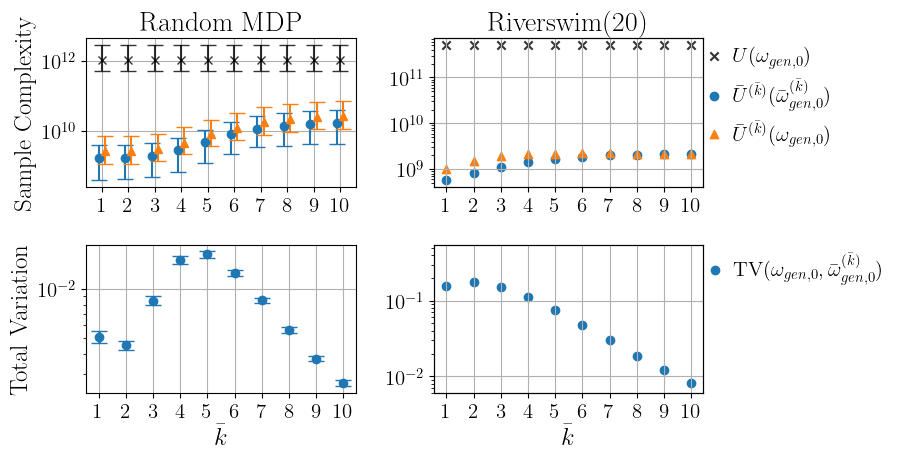

In [16]:

nk = 10
k_values = np.arange(1, nk+1)
fig,ax = plt.subplots(2,2, figsize=(10,5))

trans1 = Affine2D().translate(-0.12, 0.0) + ax[0,0].transData
trans2 = Affine2D().translate(+0.12, 0.0) + ax[0,0].transData

def compute_ce_median(values):
    ce = list(map(lambda k: bootstrap((values[:,k],), np.median, confidence_level=0.95).confidence_interval, range(values.shape[1])))
    res = np.array([(x.low, x.high) for x in ce])
    return res[:, 0], res[:, 1]


mu = np.median(random_values_U0[:, :nk], axis=0)
ce_low, ce_high = compute_ce_median(random_values_U0[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[0,0].errorbar(k_values, mu, ce, fmt='o', linewidth=1.5, capsize=6, transform=trans1,  label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')


mu = np.median(random_values_polU_U0[:, :nk], axis=0)
ce_low, ce_high = compute_ce_median(random_values_polU_U0[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[0,0].errorbar(k_values, mu, ce, fmt='^', linewidth=1.5, capsize=6, transform=trans2,  label=r'$\bar U^{(\bar k)}(\omega_{gen,0})$')

mu = np.median(random_values_U, axis=0)
ce_low, ce_high = compute_ce_median(random_values_U[:, np.newaxis])

ce = np.vstack([ce_low, ce_high])
ax[0,0].errorbar(k_values, mu*np.ones(nk), ce*np.ones(nk), fmt='x', linewidth=1.5, capsize=6, color='k', alpha=0.8,label=r'$U(\omega_{gen,0})$')

ax[0,0].set_xticks(k_values)
#ax[0,0].set_ylabel(r'Sample Complexity')
ax[0,0].grid()
ax[0,0].set_yscale('log')





ax[0,1].scatter(k_values, riverswim_values_U*np.ones(nk),marker='x',alpha=0.8, color='k', label=r'$U(\omega_{gen,0})$')
ax[0,1].scatter(k_values, riverswim_values_U0, marker='o',   label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')
ax[0,1].scatter(k_values, riverswim_values_polU_U0, marker='^',  label=r'$\bar U^{(\bar k)}(\omega_{gen,0})$')



ax[0,1].set_xticks(k_values)

ax[0,1].grid()
ax[0,1].set_yscale('log')
ax[0,1].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)

ax[1,1].scatter(k_values, riverswim_TV_polU0_vs_polU, marker='o', label=r'${\rm TV}(\omega_{gen,0}, \bar \omega_{gen,0}^{(\bar k)})$')

ax[1,1].set_xticks(k_values)
ax[1,1].set_xlabel(r'$\bar k$')
#ax[1,0].set_ylabel(r'${\rm TV}(\omega_{gen,0}, \bar \omega_{gen,0}^{(\bar k)})$')
ax[1,1].grid()
#ax[3].legend(  handlelength=1, ncols=1, framealpha=0.6)
ax[1,1].set_yscale('log')










mu, ce = CE((random_TV_polU0_vs_polU[:, :nk]))

ax[1,0].errorbar(k_values, mu, ce, fmt='o', linewidth=2, capsize=6, label=r'${\rm TV}(\omega_{gen,0}, \bar \omega_{gen,0}^{(\bar k)})$')
ax[1,0].set_xticks(k_values)
#ax[0,1].set_xlabel(r'$\bar k$')
#ax[2].set_title('Total variation between allocations')
ax[1,0].grid()
ax[1,0].set_xlabel(r'$\bar k$')
#ax[1,0].legend(  handlelength=1, ncols=1, framealpha=0.6)
ax[1,0].set_yscale('log')
from matplotlib.ticker import StrMethodFormatter, NullFormatter,LogFormatterSciNotation

ax[1,0].yaxis.set_minor_formatter(NullFormatter())

ax[1,1].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1.7, 1), borderaxespad=0)
ax2 = ax[0,1].twinx() 
ax2.set_yticks([])
ax[0,0].set_ylabel('Sample Complexity')
ax[0,0].set_title('RandomMDP')

ax2 = ax[1,1].twinx() 
ax2.set_yticks([])
ax[1,0].set_ylabel(r'Total Variation')
ax[0,1].set_title('Riverswim(20)')
ax[1,1].yaxis.set_minor_formatter(NullFormatter())
ax[1,1].set_ylim((0.006, .55))
plt.tight_layout()
plt.savefig('comparison_random_mdp_riverswim.pdf')
plt.plot()
#tikzplotlib.save(f"policy_tv_plot.tex", axis_width='0.41\columnwidth')# figurewidth='width=0.41\columnwidth,')
# tikzplotlib.get_tikz_code(fig)

[]

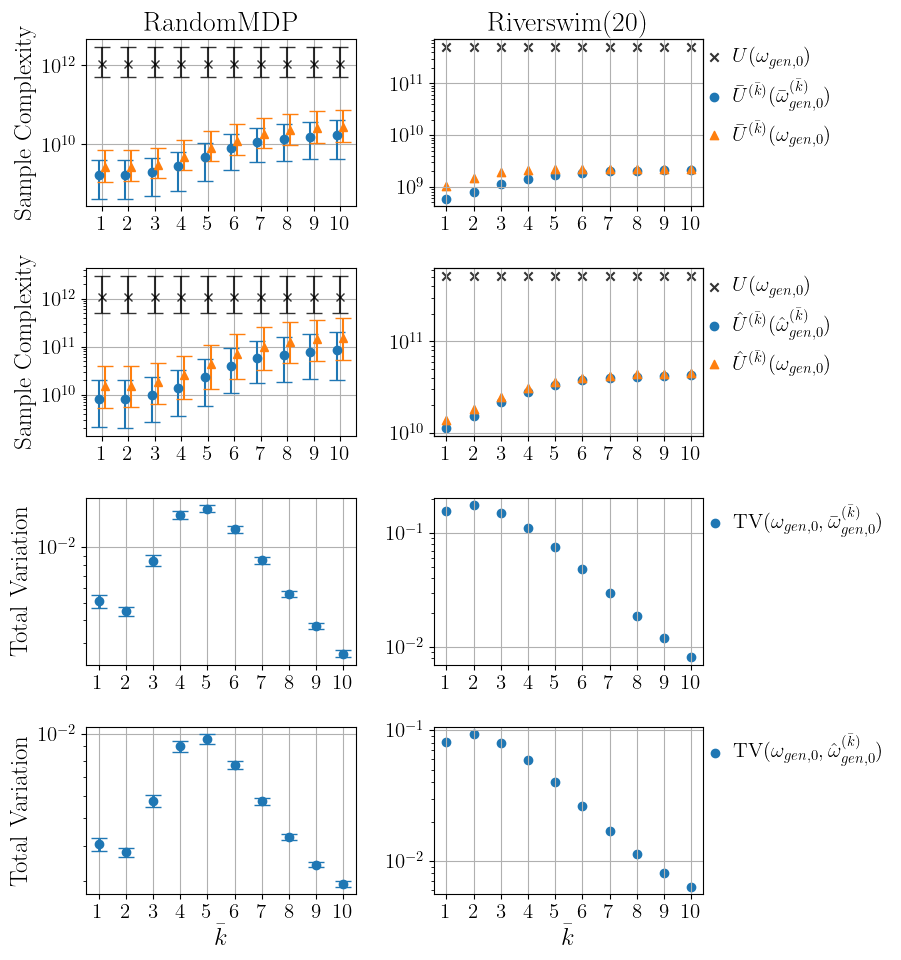

In [22]:

nk = 10
k_values = np.arange(1, nk+1)
fig,ax = plt.subplots(4,2, figsize=(10,10))

trans1 = Affine2D().translate(-0.12, 0.0) + ax[0,0].transData
trans2 = Affine2D().translate(+0.12, 0.0) + ax[0,0].transData

trans3 = Affine2D().translate(-0.12, 0.0) + ax[1,0].transData
trans4 = Affine2D().translate(+0.12, 0.0) + ax[1,0].transData

def compute_ce_median(values):
    ce = list(map(lambda k: bootstrap((values[:,k],), np.median, confidence_level=0.95).confidence_interval, range(values.shape[1])))
    res = np.array([(x.low, x.high) for x in ce])
    return res[:, 0], res[:, 1]


mu = np.median(random_values_U0[:, :nk], axis=0)
ce_low, ce_high = compute_ce_median(random_values_U0[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[0,0].errorbar(k_values, mu, ce, fmt='o', linewidth=1.5, capsize=6, transform=trans1,  label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')


mu = np.median(random_values_polU_U0[:, :nk], axis=0)
ce_low, ce_high = compute_ce_median(random_values_polU_U0[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[0,0].errorbar(k_values, mu, ce, fmt='^', linewidth=1.5, capsize=6, transform=trans2,  label=r'$\bar U^{(\bar k)}(\omega_{gen,0})$')

mu = np.median(random_values_U, axis=0)
ce_low, ce_high = compute_ce_median(random_values_U[:, np.newaxis])

ce = np.vstack([ce_low, ce_high])
ax[0,0].errorbar(k_values, mu*np.ones(nk), ce*np.ones(nk), fmt='x', linewidth=1.5, capsize=6, color='k', alpha=0.8,label=r'$U(\omega_{gen,0})$')

ax[0,0].set_xticks(k_values)
#ax[0,0].set_ylabel(r'Sample Complexity')
ax[0,0].grid()
ax[0,0].set_yscale('log')



mu = np.median(random_values_U1[:, :nk], axis=0)
ce_low, ce_high = compute_ce_median(random_values_U1[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[1,0].errorbar(k_values, mu, ce, fmt='o', linewidth=1.5, capsize=6, transform=trans3,  label=r'$\hat U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')


mu = np.median(random_values_polU_U1[:, :nk], axis=0)
ce_low, ce_high = compute_ce_median(random_values_polU_U1[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[1,0].errorbar(k_values, mu, ce, fmt='^', linewidth=1.5, capsize=6, transform=trans4,  label=r'$\hat U^{(\bar k)}(\omega_{gen,0})$')

mu = np.median(random_values_U, axis=0)
ce_low, ce_high = compute_ce_median(random_values_U[:, np.newaxis])

ce = np.vstack([ce_low, ce_high])
ax[1,0].errorbar(k_values, mu*np.ones(nk), ce*np.ones(nk), fmt='x', linewidth=1.5, capsize=6, color='k', alpha=0.8,label=r'$U(\omega_{gen,0})$')

ax[1,0].set_xticks(k_values)
#ax[0,0].set_ylabel(r'Sample Complexity')
ax[1,0].grid()
ax[1,0].set_yscale('log')


ax[0,1].scatter(k_values, riverswim_values_U*np.ones(nk),marker='x',alpha=0.8, color='k', label=r'$U(\omega_{gen,0})$')
ax[0,1].scatter(k_values, riverswim_values_U0, marker='o',   label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')
ax[0,1].scatter(k_values, riverswim_values_polU_U0, marker='^',  label=r'$\bar U^{(\bar k)}(\omega_{gen,0})$')



ax[0,1].set_xticks(k_values)

ax[0,1].grid()
ax[0,1].set_yscale('log')
ax[0,1].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)



#####
ax[1,1].scatter(k_values, riverswim_values_U*np.ones(nk),marker='x',alpha=0.8, color='k', label=r'$U(\omega_{gen,0})$')
ax[1,1].scatter(k_values, riverswim_values_U1, marker='o',   label=r'$\hat U^{(\bar k)}(\hat \omega_{gen,0}^{(\bar k)})$')
ax[1,1].scatter(k_values, riverswim_values_polU_U1, marker='^',  label=r'$\hat U^{(\bar k)}(\omega_{gen,0})$')



ax[1,1].set_xticks(k_values)

ax[1,1].grid()
ax[1,1].set_yscale('log')
ax[1,1].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)
####

ax[2,1].scatter(k_values, riverswim_TV_polU0_vs_polU, marker='o', label=r'${\rm TV}(\omega_{gen,0}, \bar \omega_{gen,0}^{(\bar k)})$')

ax[2,1].set_xticks(k_values)
#ax[1,0].set_ylabel(r'${\rm TV}(\omega_{gen,0}, \bar \omega_{gen,0}^{(\bar k)})$')
ax[2,1].grid()
#ax[3].legend(  handlelength=1, ncols=1, framealpha=0.6)
ax[2,1].set_yscale('log')


####

ax[3,1].scatter(k_values, riverswim_TV_polU1_vs_polU, marker='o', label=r'${\rm TV}(\omega_{gen,0}, \hat \omega_{gen,0}^{(\bar k)})$')

ax[3,1].set_xticks(k_values)
ax[3,1].set_xlabel(r'$\bar k$')
ax[3,1].grid()
#ax[3].legend(  handlelength=1, ncols=1, framealpha=0.6)
ax[3,1].set_yscale('log')







mu, ce = CE((random_TV_polU0_vs_polU[:, :nk]))

ax[2,0].errorbar(k_values, mu, ce, fmt='o', linewidth=2, capsize=6, label=r'${\rm TV}(\omega_{gen,0}, \bar \omega_{gen,0}^{(\bar k)})$')
ax[2,0].set_xticks(k_values)
ax[2,0].grid()
ax[2,0].set_yscale('log')

mu, ce = CE((random_TV_polU1_vs_polU[:, :nk]))

ax[3,0].errorbar(k_values, mu, ce, fmt='o', linewidth=2, capsize=6, label=r'${\rm TV}(\omega_{gen,0}, \hat \omega_{gen,0}^{(\bar k)})$')
ax[3,0].set_xticks(k_values)
ax[3,0].grid()
ax[3,0].set_xlabel(r'$\bar k$')
ax[3,0].set_yscale('log')






from matplotlib.ticker import StrMethodFormatter, NullFormatter,LogFormatterSciNotation

ax[2,0].yaxis.set_minor_formatter(NullFormatter())
ax[3,0].yaxis.set_minor_formatter(NullFormatter())
ax[2,1].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1.7, 1), borderaxespad=0)
ax[3,1].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1.7, 1), borderaxespad=0)
ax2 = ax[0,1].twinx() 
ax2.set_yticks([])
ax[0,0].set_ylabel('Sample Complexity')
ax[1,0].set_ylabel('Sample Complexity')
ax[0,0].set_title('RandomMDP')

ax2 = ax[1,1].twinx() 
ax2.set_yticks([])
ax[2,0].set_ylabel(r'Total Variation')
ax[3,0].set_ylabel(r'Total Variation')
ax[0,1].set_title('Riverswim(20)')
plt.tight_layout()
plt.savefig('comparison_random_mdp_riverswim2.pdf')
plt.plot()
#tikzplotlib.save(f"policy_tv_plot.tex", axis_width='0.41\columnwidth')# figurewidth='width=0.41\columnwidth,')
# tikzplotlib.get_tikz_code(fig)

In [74]:
N=300
delta_min = np.zeros(N)
var_v = np.zeros((N, 5, 4))
span_v = np.zeros((N, 5, 4))
delta_sa = np.zeros((N, 5, 4))
for i in tqdm(range(N)):
    P = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(ns, na)) #
    R = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(ns, na))
    mdp = MDPDescription(P, R, discount_factor)
    delta_min[i] = mdp.delta_sq_min ** 0.5
    var_v[i] = mdp.var_V_greedy
    span_v[i] = mdp.span_V_greedy
    delta_sa[i] = mdp.delta_sq ** 0.5
    

100%|██████████| 300/300 [00:31<00:00,  9.53it/s]


In [81]:
print('RandomMDP')
print(f'Delta_min: {CE(delta_min)}')
print(f'delta max: {CE(delta_sa.reshape(N,-1).max(-1))}')
print(f'span max: {CE(span_v.reshape(N,-1).max(-1))}')
print(f'span min: {CE(span_v.reshape(N,-1).min(-1))}')
print(f'Var max: {CE(var_v.reshape(N,-1).max(-1))}')
print(f'Var min: {CE(var_v.reshape(N,-1).min(-1))}')

Delta_min: (0.010828715094865457, 0.0011395209789300492)
delta max: (0.19689615739090538, 0.008269823544614521)
span max: (0.10223990033406173, 0.006527425641842989)
span min: (0.06468703505562326, 0.003995024988195072)
Var max: (0.0038321566152491947, 0.0005812208336035195)
Var min: (0.0008601745694666837, 0.00013869758334689584)


In [6]:
print('RiverSwim')
env = RiverSwim(num_states=20)
mdp = MDPDescription(env.transitions, env.rewards, discount_factor)

print(f'Delta_min: {mdp.delta_sq_min ** 0.5}')
print(f'delta max: {(mdp.delta_sq ** 0.5).max()}')
print(f'span max: {mdp.span_V_greedy.max()}')
print(f'span min: {mdp.span_V_greedy.min()}')
print(f'Var max: {mdp.var_V_greedy.max()}')
print(f'Var min: {mdp.var_V_greedy.min()}')

RiverSwim
Delta_min: 0.04608849870719922
delta max: 1.3279392942230217
span max: 13.871981037315043
span min: 7.151606310099515
Var max: 0.4253940018542721
Var min: 0.0
